# TRƯỜNG ĐẠI HỌC SƯ PHẠM KỸ THUẬT THÀNH PHỐ HỒ CHÍ MINH
## KHOA CÔNG NGHỆ THÔNG TIN
### BỘ MÔN KỸ THUẬT DỮ LIỆU

# Đề tài:
# ỨNG DỤNG PHƯƠNG PHÁP THỐNG KÊ VÀ HỌC MÁY ĐỂ DỰ ĐOÁN GIÁ NÔNG SẢN

Sinh viên 1: Huỳnh Hạo Nhị - 20133006

Sinh viên 2: Võ Hoài Thương - 20233012

# Thư viện

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.graph_objects as go

# Dữ liệu

## Giá cà phê nội địa

Dữ liệu về giá cà phê được thu thập của tỉnh Đăk Lăk, từ website của Viện Chính sách và Chiến lược Phát triển Nông nghiệp Nông thôn từ năm 2007 đến nay.
*   date*: ngày
*   price: giá cà phê


In [ ]:
df_coffee = pd.read_csv('https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/CaPhe/gia_cafe.csv', encoding='ISO-8859-1')
df_coffee.tail()

,date,price
6353,5/28/2024,116700.0
6354,5/29/2024,120700.0
6355,5/30/2024,122700.0
6356,5/31/2024,123500.0
6357,6/1/2024,120000.0


In [ ]:
df_coffee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6358 entries, 0 to 6357
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    6358 non-null   object 
 1   price   6358 non-null   float64
dtypes: float64(1), object(1)
memory usage: 99.5+ KB


In [ ]:
df_coffee['date'] = pd.to_datetime(df_coffee['date'])
df_coffee.set_index('date', inplace=True)

### Điền dữ liệu ngày thiếu

In [ ]:
idx = pd.date_range(df_coffee.index.min(), df_coffee.index.max())
df_coffee = df_coffee.reindex(idx)
df_coffee.fillna(method='ffill', inplace=True)
df_coffee.tail()

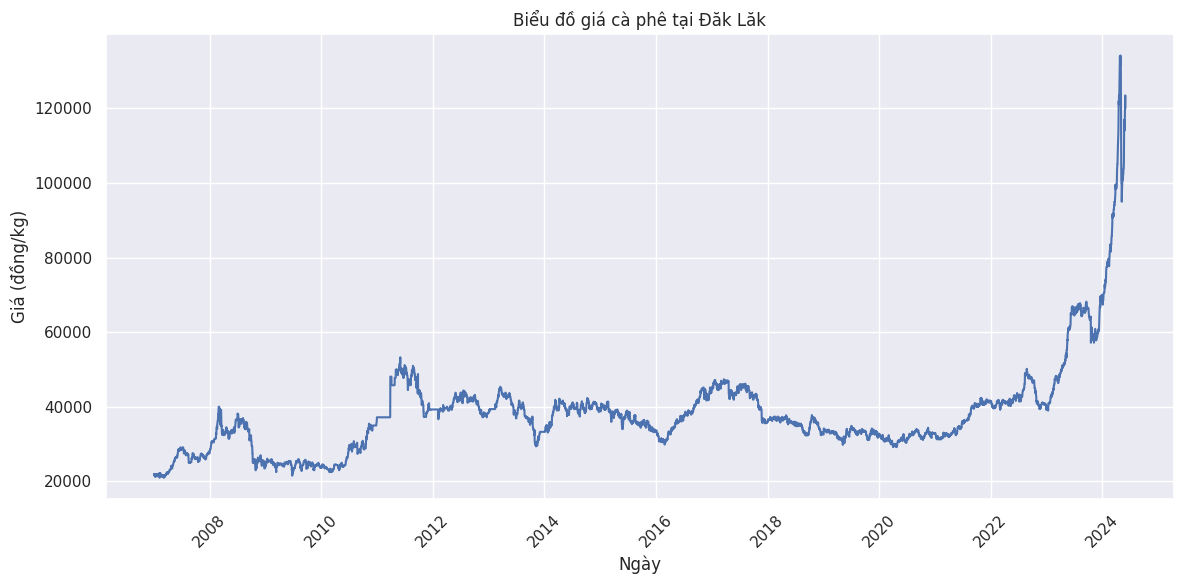

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_coffee, x=df_coffee.index, y='price')
plt.title('Biểu đồ giá cà phê tại Đăk Lăk')
plt.xlabel('Ngày')
plt.ylabel('Giá (đồng/kg)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Giá xăng

Dữ liệu giá xăng thu thập từ website của Công ty Dầu Việt Nam – CTCP.
*   date*: ngày
*   RON 95-III: giá xăng Ron 95-III

In [ ]:
df_gasoline = pd.read_csv('https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Xang/gia_xang.csv', encoding='ISO-8859-1')
df_gasoline.tail()

,date,RON 95-III
170,2/5/2024,24.95
171,9/5/2024,23.54
172,16/05/2024,23.13
173,23/05/2024,23.21
174,29/05/2024,23.21


### Xử lý outlier

<Axes: >

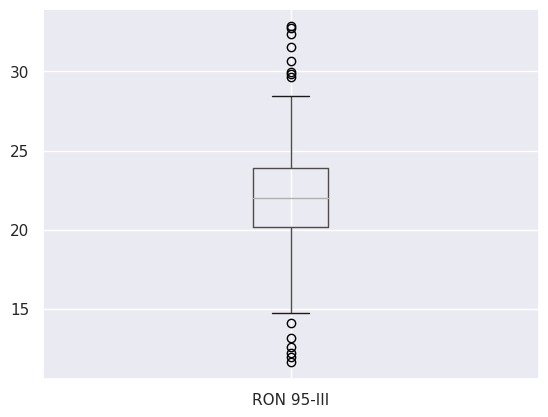

In [ ]:
df_gasoline[['RON 95-III']].boxplot()

In [ ]:
# Tính toán ngưỡng cho outlier sử dụng IQR
Q1 = df_gasoline['RON 95-III'].quantile(0.25)
Q3 = df_gasoline['RON 95-III'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [ ]:
# Xác định các dòng dữ liệu có giá trị nằm ngoài ngưỡng
outliers = df_gasoline[(df_gasoline['RON 95-III'] < lower_bound) | (df_gasoline['RON 95-III'] > upper_bound)]
print("Số lượng outlier:", len(outliers))

Số lượng outlier: 14


In [ ]:
# Kiểm tra và thay đổi giá trị nếu nó nằm ngoài ngưỡng
df_gasoline.at[df_gasoline.index[0], 'RON 95-III'] = min(max(df_gasoline.iloc[0]['RON 95-III'], lower_bound), upper_bound)

# Thay thế giá trị của outlier bằng giá trị trước đó
for index, row in outliers.iterrows():
    previous_date_index = df_gasoline.index.get_loc(index) - 1
    if previous_date_index >= 0:
        previous_date = df_gasoline.index[previous_date_index]
        previous_value = df_gasoline.loc[previous_date, 'RON 95-III']
        df_gasoline.at[index, 'RON 95-III'] = previous_value

<Axes: >

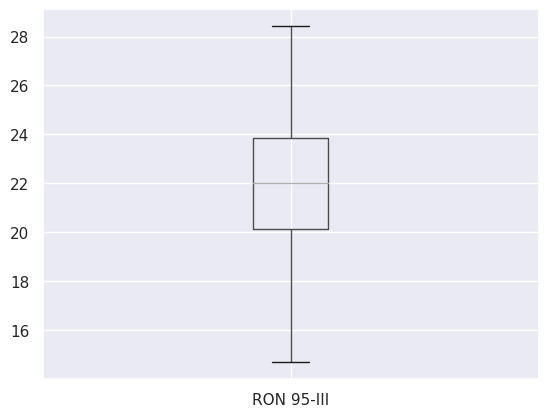

In [ ]:
df_gasoline[['RON 95-III']].boxplot()

### Fill dữ liệu ngày bị thiếu

In [ ]:
df_gasoline['date'] = pd.to_datetime(df_gasoline['date'])
df_gasoline.set_index('date', inplace=True)

<ipython-input-147-2ca4586e2886>:1: UserWarning:

Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



In [ ]:
idx = pd.date_range(df_gasoline.index.min(), df_gasoline.index.max())
df_gasoline = df_gasoline.reindex(idx)
df_gasoline.fillna(method='ffill', inplace=True)

### Merge dữ liệu xăng với cà phê

In [ ]:
start_date = df_gasoline.index.min()
df_coffee_filtered = df_coffee.loc[start_date:]

df_merged_gasoline = pd.merge(df_coffee_filtered, df_gasoline[['RON 95-III']], left_index=True, right_index=True, how='left')
df_merged_gasoline['RON 95-III'] = df_merged_gasoline['RON 95-III'].ffill()

print(df_merged_gasoline.tail())

               price  RON 95-III
date                            
2024-05-28  116700.0       23.21
2024-05-29  120700.0       23.21
2024-05-30  122700.0       23.21
2024-05-31  123500.0       23.21
2024-06-01  120000.0       23.21


In [ ]:
correlation_matrix = df_merged_gasoline.corr()

plt.figure(figsize=(6, 6), dpi=75)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=.5, cmap='coolwarm', center=0)
plt.title('Biểu đồ nhiệt ma trận tương quan')
plt.show()

### Làm mịn dữ liệu

In [ ]:
df_merged_gasoline = df_merged_gasoline.rolling(window=30, min_periods=1).mean()

# Mô hình GRU dự đoán

Gated Recurrent Unit (GRU)  là mạng nơ-ron hồi quy có khả năng xử lý chuỗi thời gian dài hạn, là biến thể đơn giản hóa từ Long Short-Term Memory (LSTM) với cấu trúc gồm hai cổng:
*   Cổng đặt lại (r): xác định phần thông tin của trạng thái ẩn trước cần loại bỏ bằng hàm sigmoid.
*   Cổng cập nhật (z): xác định thông tin nào từ trạng thái ẩn trước được giữ lại và thông tin mới nào sẽ được thêm vào bằng hàm sigmoid.
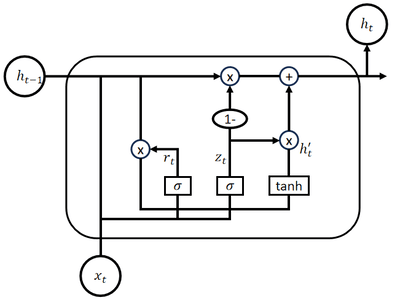

## Dữ liệu giá cà phê, giá xăng

### Xây dựng mô hình

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# Preprocess data
scaler_price = MinMaxScaler(feature_range=(0, 1))
scaled_price = scaler_price.fit_transform(df_merged_gasoline[['price']])

scaler_export = MinMaxScaler(feature_range=(0, 1))
scaled_export = scaler_export.fit_transform(df_merged_gasoline[['RON 95-III']])

scaled_data = np.concatenate((scaled_price, scaled_export), axis=1)

In [ ]:
seq_length = 30
X, y = create_sequences(scaled_data, seq_length)

In [ ]:
X.shape, y.shape

((2078, 30, 2), (2078,))

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Kích thước tập huấn luyện:", X_train.shape, y_train.shape)
print("Kích thước tập kiểm tra:", X_test.shape, y_test.shape)

Kích thước tập huấn luyện: (1662, 30, 2) (1662,)
Kích thước tập kiểm tra: (416, 30, 2) (416,)


In [ ]:
model = Sequential()
model.add(GRU(units=128, input_shape=(seq_length, 2)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=64, callbacks=[early_stopping])

Epoch 1/50
26/26 [==============================] - 3s 40ms/step - loss: 0.0016
Epoch 2/50
26/26 [==============================] - 1s 40ms/step - loss: 4.4074e-04
Epoch 3/50
26/26 [==============================] - 1s 40ms/step - loss: 2.6867e-04
Epoch 4/50
26/26 [==============================] - 1s 40ms/step - loss: 1.8145e-04
Epoch 5/50
26/26 [==============================] - 1s 40ms/step - loss: 1.3650e-04
Epoch 6/50
26/26 [==============================] - 1s 50ms/step - loss: 1.1365e-04
Epoch 7/50
26/26 [==============================] - 2s 73ms/step - loss: 1.0995e-04
Epoch 8/50
26/26 [==============================] - 2s 57ms/step - loss: 8.5452e-05
Epoch 9/50
26/26 [==============================] - 1s 40ms/step - loss: 7.5355e-05
Epoch 10/50
26/26 [==============================] - 1s 40ms/step - loss: 6.4410e-05
Epoch 11/50
26/26 [==============================] - 1s 41ms/step - loss: 6.4254e-05
Epoch 12/50
26/26 [==============================] - 1s 40ms/step - loss: 5.89

### Dự đoán trên tập train

In [ ]:
train_predictions = model.predict(X_train)

52/52 [==============================] - 1s 8ms/step


In [ ]:
train_predictions = scaler_price.inverse_transform(train_predictions)
y_train = scaler_price.inverse_transform(y_train.reshape(-1, 1))

In [ ]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_mape = calculate_mape(y_train, train_predictions)

print(f'Training RMSE: {train_rmse:.2f}')
print(f'Training MAPE: {train_mape:.2f}%')

Training RMSE: 130.28
Training MAPE: 0.28%


In [ ]:
dates = df_merged_gasoline.index.tolist()

fig = go.Figure()

fig.add_trace(go.Scatter(x=dates[:len(y_train)], y=y_train.flatten(), mode='lines', name='Giá thực tế', line=dict(width=2)))
fig.add_trace(go.Scatter(x=dates[:len(train_predictions)], y=train_predictions.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='orange', width=2)))

fig.update_layout(
    title={
        'text': 'Biểu đồ dự đoán giá cà phê trên tập huấn luyện (mô hình GRU, dữ liệu giá cà phê, giá xăng)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Ngày',
    yaxis_title='Giá (đồng/kg)',
    xaxis_tickangle=45,
    width=1200,
    height=600
)

fig.show()

### Dự đoán trên tập test

In [ ]:
test_predictions = model.predict(X_test)

13/13 [==============================] - 0s 9ms/step


In [ ]:
test_predictions = scaler_price.inverse_transform(test_predictions)
y_test = scaler_price.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mape = calculate_mape(y_test, test_predictions)

print(f'Testing RMSE: {test_rmse:.2f}')
print(f'Testing MAPE: {test_mape:.2f}%')

Testing RMSE: 500.44
Testing MAPE: 0.47%


In [ ]:
dates = df_merged_gasoline.index.tolist()

fig = go.Figure()

fig.add_trace(go.Scatter(x=dates[:len(y_train)], y=y_train.flatten(), mode='lines', name='Giá thực tế', line=dict(width=2)))
fig.add_trace(go.Scatter(x=dates[:len(train_predictions)], y=train_predictions.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='orange', width=2)))

fig.update_layout(
    title={
        'text': 'Biểu đồ dự đoán giá cà phê trên tập huấn luyện (mô hình LSTM, dữ liệu giá cà phê và giá xăng)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Ngày',
    yaxis_title='Giá (đồng/kg)',
    xaxis_tickangle=45,
    width=1200,
    height=600
)

fig.show()

### Đánh giá kết quả

In [ ]:
results = pd.DataFrame({
    '': ['Train', 'Test'],
    'RMSE': [train_rmse, test_rmse],
    'MAPE (%)': [train_mape, test_mape]
})
results = results.round(2)

print(results)

            RMSE  MAPE (%)
0  Train  130.28      0.28
1   Test  500.44      0.47


### Lưu mô hình

In [ ]:
# model.save('GRU_gia_cafe_xang.h5')